In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit.Chem.Lipinski as l
import rdkit.Chem.Fragments as f
from rdkit.Chem import Descriptors
import rdkit.Chem.rdMolDescriptors as d

from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import VotingClassifier

In [11]:
def binaryToInt(list):
  return int("".join(str(i) for i in list),2)

def aromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  return np.sum([1 if i == True else 0 for i in aromatic_atoms])

# Append all feature values to a list
def getFeatureValsForM(m):
  features = []
  features.append(f.fr_halogen(m))
  features.append(f.fr_Al_COO(m))
  features.append(l.NHOHCount(m))
  features.append(l.NumHAcceptors(m))
  features.append(l.NumHDonors(m))
  features.append(l.NumHeteroatoms(m))
  features.append(l.NumAliphaticRings(m))
  features.append(l.HeavyAtomCount(m))
  features.append(Descriptors.MolLogP(m))
  features.append(Descriptors.MolWt(m))
  features.append(Descriptors.NumRotatableBonds(m))
  features.append(aromaticAtoms(m))
  features.append(aromaticAtoms(m)/Descriptors.HeavyAtomCount(m))
  fp = AllChem.GetMorganFingerprintAsBitVect(m,2,nBits=124)
  features.append(binaryToInt(fp))
  return features

# Extract features and add it to DF
def extractFeatures(raw_data):
  data = []
  for smile in raw_data['SMILES']:
    m = Chem.MolFromSmiles(smile)
    feature_vals = getFeatureValsForM(m)
    columns = ['x' + str(i + 1) for i in range(len(feature_vals))]
    data.append(dict(zip(columns, feature_vals)))
  return pd.DataFrame(data)

def plotROCAUC(model, X_test, y_test):
  #model.fit(X_train, y_train)
  probs = model.predict_proba(X_test)
  preds = probs[:,1]
  fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  print('AUC score on train/test split: ' + str(roc_auc))

## Read in and transform training data

In [4]:
raw_train_data = pd.read_csv('new_training_smiles.csv')
raw_train_data.drop('Unnamed: 0', axis=1, inplace=True)
display(raw_train_data)

y_train = [int(label) for label in raw_train_data['ACTIVE'].values]
raw_train_data.drop(['ACTIVE'], axis=1, inplace=True)
X_train = extractFeatures(raw_train_data)
display(X_train)

X_train.drop(['x3', 'x8', 'x12'], axis=1, inplace=True)
X_train.drop(['x1', 'x7'], axis=1, inplace=True)
display(X_train)

,SMILES,ACTIVE
0,C=C(C)c1cccc(C(C)(C)NC(=O)Nc2cc(C)ccc2OC)c1,0.0
1,CCOC(=O)c1cnn2c(C(F)(F)F)cc(-c3cn(C)nc3C)nc12,0.0
2,COc1ccccc1-n1cnc2cc(NC(=O)c3ccco3)ccc21,0.0
3,COc1c(CO)cc(CO)cc(CO)c1=O,0.0
4,COC(=O)CN1C(=S)N(c2ccc(OC)cc2)C(=O)/C1=C/c1cccs1,0.0
...,...,...
133704,c1ccc(Cn2ccnc2-c2ccco2)cc1,0.0
133705,CCOC(=O)c1cnc2c(-c3ccc(Cl)cc3)cnn2c1C,0.0
133706,COc1cc(C(=O)Oc2cccc(C)c2)cc(OC)c1OC,0.0
133707,CC(=O)Nc1cc2c(cc1C(=O)C(C)C)OCCO2,0.0


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
0,0,0,2,2,2,4,0,25,5.09352,338.451,5,12,0.480000,5671210215184166703700378702203336722
1,3,0,0,7,0,10,0,25,2.63372,353.304,3,14,0.560000,4476816478950354051105503996738056205
2,0,0,1,5,1,6,0,25,3.87940,333.347,4,20,0.800000,523695094110335032410745669696142338
3,0,0,3,5,3,5,0,16,-0.46770,226.228,4,7,0.437500,21357387526891337304840442166116352
4,0,0,0,6,0,8,1,26,2.90430,388.470,5,11,0.423077,9660721225630434155249162382398199314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133704,0,0,0,3,0,3,0,17,3.19140,224.263,3,16,0.941176,607503884757588786199083587247138058
133705,1,0,0,5,0,6,0,22,3.53482,315.760,3,15,0.681818,623168840203088061610875933794848774
133706,0,0,0,5,0,5,0,22,3.24002,302.326,5,12,0.545455,1682720011216148433928110003258920962
133707,0,0,1,4,1,5,1,19,2.25490,263.293,3,6,0.315789,5743091227781309622800876834866108448


,x2,x4,x5,x6,x9,x10,x11,x13,x14
0,0,2,2,4,5.09352,338.451,5,0.480000,5671210215184166703700378702203336722
1,0,7,0,10,2.63372,353.304,3,0.560000,4476816478950354051105503996738056205
2,0,5,1,6,3.87940,333.347,4,0.800000,523695094110335032410745669696142338
3,0,5,3,5,-0.46770,226.228,4,0.437500,21357387526891337304840442166116352
4,0,6,0,8,2.90430,388.470,5,0.423077,9660721225630434155249162382398199314
...,...,...,...,...,...,...,...,...,...
133704,0,3,0,3,3.19140,224.263,3,0.941176,607503884757588786199083587247138058
133705,0,5,0,6,3.53482,315.760,3,0.681818,623168840203088061610875933794848774
133706,0,5,0,5,3.24002,302.326,5,0.545455,1682720011216148433928110003258920962
133707,0,4,1,5,2.25490,263.293,3,0.315789,5743091227781309622800876834866108448


## Read in and transform AUC_est data

In [5]:
raw_AUCest_data = pd.read_csv('auc_est_training_smiles.csv')
raw_AUCest_data.drop('Unnamed: 0', axis=1, inplace=True)
display(raw_AUCest_data)

y_AUCest_test = [int(label) for label in raw_AUCest_data['ACTIVE'].values]
raw_AUCest_data.drop(['ACTIVE'], axis=1, inplace=True)
X_AUCest_test = extractFeatures(raw_AUCest_data)
display(X_AUCest_test)

X_AUCest_test.drop(['x3', 'x8', 'x12'], axis=1, inplace=True)
X_AUCest_test.drop(['x1', 'x7'], axis=1, inplace=True)
display(X_AUCest_test)

,SMILES,ACTIVE
0,COc1cccc(C2=NN3C(=NN/C3=C3\C=CC=CC3=O)SC2)c1,0.0
1,N#CC1(c2ccccc2)CCN(C2CC(=O)N(c3ccc4c(c3)OCO4)C...,0.0
2,CCCCC(=O)NNC=C1C(=O)N(CC)C(=S)N(CC)C1=O,0.0
3,O=C(CSc1ncccn1)NC(=O)c1ccccc1,0.0
4,COc1ccccc1N(C(=O)CCCl)C(C#N)c1ccccc1,0.0
...,...,...
14851,Cc1ccc[n+](C2C(c3ccc([N+](=O)[O-])cc3)C(C#N)=C...,0.0
14852,Cc1ccc(-n2c(-c3nn(C)cc3Cl)n[nH]c2=S)cc1,0.0
14853,O=C(Nc1nc2ccccc2[nH]1)c1ccc(S(=O)(=O)N2CCOCC2)cc1,0.0
14854,COc1cccc(CNc2cnc3ccccc3c2)c1O,0.0


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
0,0,0,1,7,1,7,3,24,2.22900,338.392,2,6,0.250000,39347885368333433294574075357704986
1,0,0,0,6,0,7,3,30,2.60458,403.438,3,12,0.400000,19950473402565505213015506485164308266
2,0,0,2,5,2,8,1,22,0.67680,326.422,7,0,0.000000,18941583132547212796184049068238060034
3,0,0,1,5,1,6,0,19,1.52530,273.317,4,12,0.631579,355822086249945826604877407420708866
4,1,0,0,3,0,5,0,23,3.92198,328.799,6,12,0.521739,5680500484685002556390951637284583443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14851,0,0,2,6,2,8,2,29,2.49950,408.483,4,12,0.413793,6657112767678944937608439591646327322
14852,1,0,1,5,1,7,0,20,3.29221,305.794,2,16,0.800000,13386717544668514361839418001666574
14853,0,0,2,5,2,9,1,27,1.83610,386.433,4,15,0.555556,1781287580380378339832657180439394310
14854,0,0,2,4,2,4,0,21,3.56110,280.327,4,16,0.761905,2682258057825214984345853274735249410


,x2,x4,x5,x6,x9,x10,x11,x13,x14
0,0,7,1,7,2.22900,338.392,2,0.250000,39347885368333433294574075357704986
1,0,6,0,7,2.60458,403.438,3,0.400000,19950473402565505213015506485164308266
2,0,5,2,8,0.67680,326.422,7,0.000000,18941583132547212796184049068238060034
3,0,5,1,6,1.52530,273.317,4,0.631579,355822086249945826604877407420708866
4,0,3,0,5,3.92198,328.799,6,0.521739,5680500484685002556390951637284583443
...,...,...,...,...,...,...,...,...,...
14851,0,6,2,8,2.49950,408.483,4,0.413793,6657112767678944937608439591646327322
14852,0,5,1,7,3.29221,305.794,2,0.800000,13386717544668514361839418001666574
14853,0,5,2,9,1.83610,386.433,4,0.555556,1781287580380378339832657180439394310
14854,0,4,2,4,3.56110,280.327,4,0.761905,2682258057825214984345853274735249410


## Read in and transform unseen test data

In [8]:
raw_test_data = pd.read_csv('test_smiles.csv')
raw_test_data.drop('INDEX', axis=1, inplace=True)
display(raw_test_data)

X_test = extractFeatures(raw_test_data)
display(X_test)

X_test.drop(['x3', 'x8', 'x12'], axis=1, inplace=True)
X_test.drop(['x1', 'x7'], axis=1, inplace=True)
display(X_test)

,SMILES
0,Cc1cc(N2CCCCC2)nc(N2CCCCC2)n1
1,O=C(NCc1ccc(Cl)cc1Cl)C(=O)N1CCCCC1
2,CCO.Cc1cc(C)n(CCc2nc(-c3ccc(-c4ccccc4)cc3)cs2)n1
3,Cc1ccc(S(=O)(=O)NCc2ccco2)cc1C(N)=O
4,CCN(CC)CCCCCOc1ccccc1OC
...,...
49517,CCNc1ccc(S(=O)(=O)N(C)C)cc1NCC(=O)Nc1ccc(Br)cc1F
49518,COc1ccc(NC(=O)CSc2nc3c([nH]c4ccccc43)c(=O)n2C)cc1
49519,CC(=O)Nc1ccc(NC(=O)COC(=O)c2ccc(C)s2)cc1
49520,Cc1ccc2c(c1)/C(=C/c1ccco1)C(=O)N2


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
0,0,0,0,4,0,4,2,19,2.76562,260.385,2,6,0.315789,1343932742798490994319552613278318981
1,2,0,1,2,1,6,1,20,2.62210,315.200,2,6,0.300000,343016170679505024291421038879741958
2,0,0,1,5,1,5,0,29,5.53174,405.567,5,22,0.758621,4073782821850292155989658465917223194
3,0,0,3,4,2,7,0,20,1.16542,294.332,5,11,0.550000,1921760924475586662724717704836136202
4,0,0,0,3,0,3,0,19,3.58610,265.397,10,6,0.315789,1682710469140777610263956389766381570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49517,2,0,3,5,3,10,0,28,3.32090,473.368,8,12,0.428571,5745865082426978718982402707615160866
49518,0,0,2,6,2,8,0,28,3.15420,394.456,5,19,0.678571,1692826962183988546693188254456092678
49519,0,0,2,5,2,7,0,23,2.81042,332.381,5,11,0.478261,332878729252561007765564946152429574
49520,0,0,1,2,1,3,1,17,3.08072,225.247,1,11,0.647059,13489998838681274777106846504687023634


,x2,x4,x5,x6,x9,x10,x11,x13,x14
0,0,4,0,4,2.76562,260.385,2,0.315789,1343932742798490994319552613278318981
1,0,2,1,6,2.62210,315.200,2,0.300000,343016170679505024291421038879741958
2,0,5,1,5,5.53174,405.567,5,0.758621,4073782821850292155989658465917223194
3,0,4,2,7,1.16542,294.332,5,0.550000,1921760924475586662724717704836136202
4,0,3,0,3,3.58610,265.397,10,0.315789,1682710469140777610263956389766381570
...,...,...,...,...,...,...,...,...,...
49517,0,5,3,10,3.32090,473.368,8,0.428571,5745865082426978718982402707615160866
49518,0,6,2,8,3.15420,394.456,5,0.678571,1692826962183988546693188254456092678
49519,0,5,2,7,2.81042,332.381,5,0.478261,332878729252561007765564946152429574
49520,0,2,1,3,3.08072,225.247,1,0.647059,13489998838681274777106846504687023634


## Train the model

In [9]:
X_train_cop = X_train.copy()
sc = StandardScaler()
X_train_cop = sc.fit_transform(X_train_cop)

rf_params = {'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_split': 6, 'n_estimators': 600, 'oob_score': True}
mlp_params = {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}

eclf = VotingClassifier(estimators=[ 
    ('rf', RandomForestClassifier(**rf_params)),
    ('mlp', MLPClassifier(**mlp_params)),
    ], voting='soft')

eclf.fit(X_train_cop, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced_subsample',
                                                     max_depth=16,
                                                     min_samples_split=6,
                                                     n_estimators=600,
                                                     oob_score=True)),
                             ('mlp',
                              MLPClassifier(alpha=0.005,
                                            hidden_layer_sizes=(50, 50, 50),
                                            learning_rate='adaptive'))],
                 voting='soft')

## Calculate AUC estimate

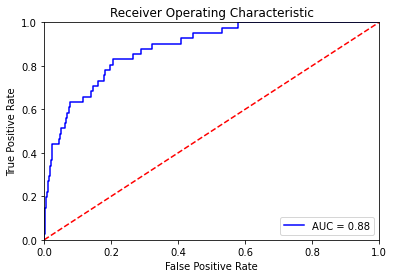

AUC score on train/test split: 0.8819472683420726


In [15]:
X_AUCest_test_cop = X_AUCest_test.copy()
sc = StandardScaler()
X_AUCest_test_cop = sc.fit_transform(X_AUCest_test_cop)
plotROCAUC(eclf, X_AUCest_test_cop, y_AUCest_test)

## Re-train model with ALL data (training + AUC estimate)

In [33]:
X_train_all = pd.concat([X_train, X_AUCest_test], ignore_index=True)
y_train_all = y_train + y_AUCest_test
display(X_train_all)
display(len(y_train_all))

,x2,x4,x5,x6,x9,x10,x11,x13,x14
0,0,2,2,4,5.09352,338.451,5,0.480000,5671210215184166703700378702203336722
1,0,7,0,10,2.63372,353.304,3,0.560000,4476816478950354051105503996738056205
2,0,5,1,6,3.87940,333.347,4,0.800000,523695094110335032410745669696142338
3,0,5,3,5,-0.46770,226.228,4,0.437500,21357387526891337304840442166116352
4,0,6,0,8,2.90430,388.470,5,0.423077,9660721225630434155249162382398199314
...,...,...,...,...,...,...,...,...,...
148560,0,6,2,8,2.49950,408.483,4,0.413793,6657112767678944937608439591646327322
148561,0,5,1,7,3.29221,305.794,2,0.800000,13386717544668514361839418001666574
148562,0,5,2,9,1.83610,386.433,4,0.555556,1781287580380378339832657180439394310
148563,0,4,2,4,3.56110,280.327,4,0.761905,2682258057825214984345853274735249410


148565

## Re-train the model on all data

In [ ]:
X_train_all_cop = X_train_all.copy()
sc = StandardScaler()
X_train_all_cop = sc.fit_transform(X_train_all_cop)

rf_params = {'class_weight': 'balanced_subsample', 'max_depth': 16, 'min_samples_split': 6, 'n_estimators': 600, 'oob_score': True}
mlp_params = {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}

eclf = VotingClassifier(estimators=[ 
    ('rf', RandomForestClassifier(**rf_params)),
    ('mlp', MLPClassifier(**mlp_params)),
    ], voting='soft')

eclf.fit(X_train_all_cop, y_train_all)

## Label unseen data

In [16]:
X_test_cop = X_test.copy()
sc = StandardScaler()
X_test_cop = sc.fit_transform(X_test_cop)
Labels = eclf.predict_proba(X_test_cop)
print(Labels)

[[9.87098784e-01 1.29012158e-02]
 [9.99024998e-01 9.75001500e-04]
 [9.90709829e-01 9.29017070e-03]
 ...
 [9.90620795e-01 9.37920517e-03]
 [7.56512530e-01 2.43487470e-01]
 [9.87919653e-01 1.20803473e-02]]


In [23]:
print(Labels[:,1])
print(len(Labels[:,1]))
print(len(raw_test_data))

predictions = pd.DataFrame({'labels':Labels[:,1]})
display(predictions)

[0.01290122 0.000975   0.00929017 ... 0.00937921 0.24348747 0.01208035]
49522
49522


,labels
0,0.012901
1,0.000975
2,0.009290
3,0.007161
4,0.000005
...,...
49517,0.000369
49518,0.014913
49519,0.009379
49520,0.243487


In [24]:
predictions.to_csv('16.txt', header=None, index=None)
predictions

,labels
0,0.012901
1,0.000975
2,0.009290
3,0.007161
4,0.000005
...,...
49517,0.000369
49518,0.014913
49519,0.009379
49520,0.243487
